<center> <img style="float: center;" src="images/CI_horizontal.png" width="450">
<center>
    <span style="font-size: 1.5em;">
        <a href='https://www.coleridgeinitiative.org'>Website</a>
    </span> 

<center><h1> Preparing and Submitting Files for Export<h1></center>


# Expectations

At the conclusion of this training you should know how to:

1. Create all the necessary supporting files for each export file.

1. Create the proper documentation.

1. Navigate the export application.

# Motivation and Outline

This presentation will walk you through how to prepare files for the export process. By no means is this list exhaustive. You can apply the techniques you learn here to the files you wish to export. This presentation is a general, high-level overview of the export process where we use publicly available data. This is not dataset-specific, and if you need specific examples the presentation prep notebook is a great resource. 

1. How to prepare an export
    - Creating all necessary files
1. How to submit an export using the files we created
    - Export module


# What is needed in an export?

1. Files for Export
    - The files you want outside of the ADRF
1. Files for Export Documentation
    - These are the supporting files that contain the underlying and non-rounded counts, data, and code used to create the files for export
1. Documentation Memo
    - This is generally a .txt or .doc file that contains detailed information about each file for export and its corresponding files for export documentation

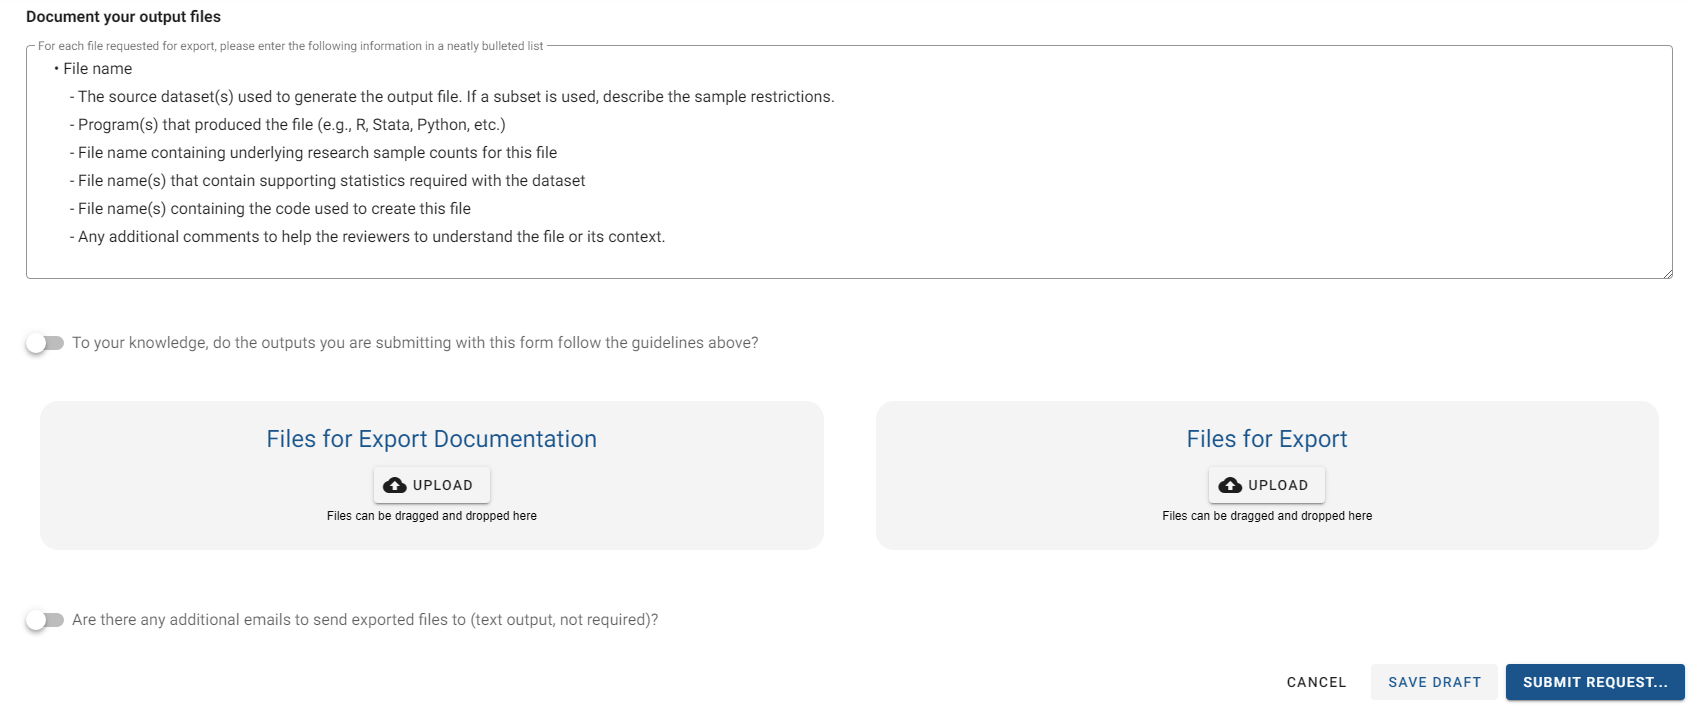

# Submitting a Proper Export

It is important to focus on the files for export documentation first. The reasons being are 1) this will dictate what you are allowed to export, and 2) you know what the desired tables and output will be. In reality, these steps are done in tandem because the underlying counts can limit what you are allowed to export.

The following supporting files for export documentation and documentation memo must accompany all files for export:
- The underlying counts/tables that created the table or graph that you wish to export
- A documentation memo that includes:
    - Export file name 
    - Name of the supporting files that contain the required counts for each reported statistic
    - Grouping and filters applied to the original dataset
    - How the export file relates to other files within the same export

>Note: If there are multiple variables subject to disclosure review, you can include the counts for them in the same file.


In [ ]:
library(tidyverse)
library(R.utils)
library(ggplot2)



In [ ]:
co_xwalk <- read_csv("co_xwalk.csv")

co_wac_2019 <- read_csv('co_wac_S000_JT00_2019.csv')

co_rac_2019 <- read_csv('co_rac_S000_JT00_2019.csv')


In [ ]:
df_inner_join <- inner_join(co_xwalk, co_wac_2019, by = c("tabblk2010" = "w_geocode")) %>%
    select (tabblk2010, C000, CA01, CA02, CA03, ctyname, cbsaname) %>% 
    filter(C000 > 10)

# How to prepare an export


In [ ]:
total_jobs_by_county <- df_inner_join %>%
    group_by(ctyname) %>% #grouping by county name
    summarize(
        total_jobs = sum(C000)
    ) %>%
    ungroup()  %>% # cant forget to ungroup()
    arrange(desc(total_jobs))

head(total_jobs_by_county)

In [ ]:
# the census block is the disclosure unit of focus so we need to include that.

total_jobs_by_county <- df_inner_join %>%
    group_by(ctyname) %>% #grouping by county name
    summarize(
        total_jobs = sum(C000), #summing the column C000
        census_block_count = n_distinct(tabblk2010) #getting counts of census blocks 
    ) %>%
    ungroup()  %>% # cant forget to ungroup()
    arrange(desc(total_jobs))

head(total_jobs_by_county)

# Export 1
## Bar Plot

In [ ]:
# calculating the proportion of jobs for each county

total_jobs_prop <- total_jobs_by_county %>%
    arrange(desc(total_jobs)) %>%
    mutate(
        prop = total_jobs/sum(total_jobs)*100) # calculating proportions
head(total_jobs_prop)

Now that we have the proportion calculated, we need to apply rounding rules.

**Rounding Rules**

Percentages, proportions and ratios need to be rounded - you must apply the rounding rules first to the true numerator and denominator before calculating any proportions. Once the proportions are calculated, they must be rounded to the nearest hundredth (.01) or the nearest percent if using whole numbers (1%).

Because we have counts of jobs, we need to apply appropriate rounding rules. Counts between 0-999 must be rounded to the nearest 10 and counts above 999 to the nearest 100.

In [ ]:
total_jobs_prop_rounded <- total_jobs_prop %>%
    mutate(
        total_jobs_rounded = ifelse(total_jobs < 1000, #applying rounding rules
                                    round(total_jobs, digits = -1), 
                                    round(total_jobs, digits = -2)),
    prop_rounded = round(total_jobs_rounded/sum(total_jobs_rounded),2) *100) 

head(total_jobs_prop_rounded)

Since we are showing the top 6 counties with the most jobs, we need to include the totals for the columns `total_jobs` and `total_jobs_rounded` to show how we calculated the proportions. We will add a row called `Total` with the sum of these 2 columns.

In [ ]:
total_df <- total_jobs_prop_rounded %>%
    summarize(total_jobs = sum(total_jobs),
              census_block_count = sum(census_block_count),
              prop = sum(census_block_count)/sum(census_block_count)*100,
              total_jobs_rounded = sum(total_jobs_rounded),
              prop_rounded = sum(total_jobs_rounded)/sum(total_jobs_rounded)*100)

total_df <- cbind(ctyname = 'Total', total_df)

In [ ]:
total_jobs_prop_rounded_w_total <- total_jobs_prop_rounded %>% 
    head() %>% 
    rbind(total_df)
total_jobs_prop_rounded_w_total


# Creating Bar Plot

In [ ]:
# Basic barplot
ggplot(data=total_jobs_prop_rounded %>% head(), aes(x=ctyname, y=prop_rounded)) +
    geom_bar(stat="identity") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))
ggsave("export_1_bar_plot.png")


When we submit the bar plot for export, we need to show the non-rounded counts for each proportion, the counts for each census block, the rounded counts that generated the proportions, and the final rounded proportions and save the resulting data frame. We ask for this because the export team needs to verify that the proper rounding rules are applied. 

In [ ]:
total_jobs_prop_rounded_w_total %>% write_csv("export_1_counts_for_bar_plot.csv")
total_jobs_prop_rounded_w_total

# Export 2

## Exporting a Quantile - Median

Now, using the same data, we are interested in calculating the median number of jobs per census block in each county.

In [ ]:
median_jobs_per_census_block <- df_inner_join %>% 
    group_by(ctyname) %>%
    summarize(
        median_jobs_census_block = median(C000) #calculating the median
    ) %>% arrange(desc(median_jobs_census_block)) %>%
    head()

median_jobs_per_census_block

In [ ]:
median_jobs_per_census_block <- df_inner_join %>% 
    group_by(ctyname) %>%
    summarize(
        median_jobs_census_block = median(C000), #calculating the median
        count_census_block = n_distinct(tabblk2010) #variable for disclosure review
    ) %>% arrange(desc(median_jobs_census_block)) %>%
    head()

median_jobs_per_census_block


We have calculated the median number of jobs per census block. But we can't export the true median because it may be a data point. Instead, we can export the fuzzy median. We also need to apply the rounding rules after calculating the fuzzy median.

Exact percentiles can not be exported - instead, for example, you may calculate a “fuzzy median” by averaging the true 45th and 55th percentiles.


In [ ]:
fuzzy_median_jobs_per_census_block <- df_inner_join %>% 
    group_by(ctyname) %>%
    summarize(
        median_jobs_census_block = median(C000),
        fuzzy_median_jobs = ((quantile(C000, .45) + quantile(C000, .55))/2), #calculating fuzzy median
        count_census_block = n_distinct(tabblk2010) #variable for disclosure review
    ) %>% 
    mutate(
        fuzzy_median_jobs_rounded = round(fuzzy_median_jobs, digits = -1)) %>%
    arrange(desc(median_jobs_census_block)) %>%
    head()

fuzzy_median_jobs_per_census_block

We see that we have a count below 10 for Crowley County, CO. This means we have to redact the `fuzzy_median_jobs_rounded` value for that record. We will replace any value fewer than 9 with `NA`.

In [ ]:
export_median_jobs_fuzzy_rounded <- fuzzy_median_jobs_per_census_block %>%
    mutate(fuzzy_median_jobs_rounded = ifelse( #applying rounding rules
            count_census_block < 10, 
               fuzzy_median_jobs_rounded == NA, 
               fuzzy_median_jobs_rounded)) %>%
    select(ctyname, fuzzy_median_jobs_rounded)

export_median_jobs_fuzzy_rounded


Now that we have applied the rounding rules and created the supporting table with the underlying counts, we need to save both data frames. 

In [ ]:
fuzzy_median_jobs_per_census_block %>% write_csv("export_2_data.csv")
export_median_jobs_fuzzy_rounded %>% write_csv("export_2_fuzzy_median_jobs.csv")

# Documentation File 

<html>
  <head>
    <title>Documentation</title>
  </head>
  <body>
      <p>Check out
      <a href="Documentation.pdf" target="_blank rel="noopener noreferrer"> Documentation Example</a></p>
  </body>
</html>


# ADRF User Guide

The user guide is a great reference for the export process or using the ADRF. 

<html>
  <head>
    <title>ADRF User Guide</title>
  </head>
  <body>
      <p>Check out
      <a href="https://acrobat.adobe.com/link/track?uri=urn:aaid:scds:US:2c9eadca-1ed8-38f7-bb89-8ba373106a83" target="_blank rel="noopener noreferrer">ADRF User Guide</p>
  </body>
</html>
<br>

<span style="font-size: 1.5em;">
        <a href='https://youtu.be/qXG_i0v_bDQ'>Export Module Video Walk-through</a>
    </span> 

In [ ]:
# jupyter nbconvert Export_training.ipynb --to slides --post serve --no-input
# jupyter nbconvert Export_training.ipynb --to pdf


In [ ]:
# pip install --user jupyter_contrib_nbextensions
# jupyter contrib nbextension install --user
# pip install --user jupyter_nbextensions_configurator
# jupyter nbextensions_configurator enable --user